In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['xtick.minor.width'] = 0

plt.rcParams['font.family'] ='HCR Dotum'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def process(file):
    df = pd.read_excel(file)
    # Set row 0 as column names
    df.columns = df.iloc[1]
    df = df[2:].reset_index(drop=True)
    
    df["전체정원"] = df["정원"].apply(lambda x: int(x.split("(")[0]))
    df["장바구니신청"] = df["장바구니신청"].astype(int)
    df["경쟁률"] = df["장바구니신청"] / df["전체정원"]
    df = df[df["전체정원"]!=0]
    df.drop(columns = ["교과목번호", "강좌번호", "부제명", "수업형태", "강의실(동-호)(#연건, *평창)", "재학생장바구니신청",
                      "신입생장바구니신청", "비고", "강의언어", "개설상태", "정원", "수강신청인원"], inplace=True)
    df["연도"] = int(file.split("/")[2][:4])
    df["학기"] = int(file.split("_")[1][0])
    df["학년"] = df["학년"].apply(lambda x: int(str(x)[0] if str.isdigit(str(x)[0]) else 0))
    return df

def semester_to_int(row):
    return row['연도'] * 10 + (1 if row['학기'] == 1 else 2)

def getDataFrame():
    files = [join("./Data/", f) for f in listdir("./Data") if isfile(join("./Data", f))]
    df = []
    for file in files:
        df.append(process(file))
    
    df = pd.concat(df)
    df = df.reset_index(drop=True)
    
    for col in ["학점", "강의", "실습"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df[["학점", "강의", "실습"]] = df[["학점", "강의", "실습"]].fillna(0)

    df["수업교시"] = df["수업교시"].fillna(0)
    df["수업교시"] = df["수업교시"].apply(lambda x: int(x.split("(")[1].split(":")[0]) + int(x.split(":")[1].split("~")[0]) / 60 if type(x)==str else x)
    
    df['semester_idx'] = df.apply(semester_to_int, axis=1)
    
    df['row_index'] = df.index
    df_sorted = df.sort_values(by=["교과목명", "semester_idx"]).reset_index(drop=True)

    return df, df_sorted

df, df_sorted = getDataFrame()

In [3]:
categorical_features = ["교과구분", "이수과정"]

numerical_features = ["학년", "학점", "강의", "실습", "수업교시", "장바구니신청", "전체정원"]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

df_clean = df[categorical_features + numerical_features].copy()
X_all = preprocessor.fit_transform(df_clean)
temp = X_all[:, -2].copy()
X_all[:, -2] = X_all[:, -1]
X_all[:, -1] = temp
X_all_sorted = X_all[df_sorted["row_index"].values]

print(X_all.shape)

(67683, 19)


In [4]:
X_seq = []
y_seq = []

window_size = 3

grouped = df_sorted.groupby("교과목명")

for name, group in grouped:
    idxs = group.index.to_list()
    datas = df_sorted.loc[idxs]
    semesters = df_sorted.loc[idxs]["semester_idx"].unique()
    
    if len(semesters) < window_size + 1:
        continue

    sem_data_list = []
    
    for i in range(len(semesters)):
        sem_data = datas[datas["semester_idx"]==semesters[i]]
        sem_data = X_all_sorted[sem_data.index.to_list()]
        sem_data_list.append(sem_data.mean(axis=0))

    sem_data_list = np.array(sem_data_list)
    
    for i in range(len(semesters) - window_size):
        seq = sem_data_list[i:i+window_size]
        target = sem_data_list[i+window_size]

        temp_lim = np.full((seq.shape[0], 1), sem_data_list[i+window_size, -2:-1])
    
        seq = np.concatenate([seq, temp_lim], axis=1)

        X_seq.append(seq)
        y_seq.append(target)

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

target_idx = [-1]
y_seq = y_seq[:, target_idx]
X_seq = np.nan_to_num(X_seq, nan=0.0)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (10096, 3, 20)
y_seq shape: (10096, 1)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

In [31]:
total_features = X_train.shape[2]
dense_features = -2
LSTM_features = -3
FIN_features = -1

input_seq = Input(shape=(window_size, total_features))

# Constants are hard-coded due to save
lstm_input = tf.keras.layers.Lambda(lambda x: x[:, :, -3:-1], output_shape=(3, 2))(input_seq)
dense_input = tf.keras.layers.Lambda(lambda x: x[:, -1, :-2], output_shape=(18,))(input_seq)
fin_input = tf.keras.layers.Lambda(lambda x: x[:, -1, -1:], output_shape=(1,))(input_seq)

x_lstm = LSTM(32, return_sequences=False)(lstm_input)
x_lstm = Dense(16, activation='relu')(x_lstm)
x_lstm = Dropout(0.1)(x_lstm)

x_dense = Dense(16, activation='relu')(dense_input)
x_dense = Dropout(0.1)(x_dense)

x = Concatenate()([x_lstm, x_dense, fin_input])

sub_dense = Dense(8)(x)
sub_dense = Dropout(0.1)(sub_dense)
output = Dense(y_train.shape[1])(sub_dense)

model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 3, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 3, 2)      │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 32)        │      4,480 │ lambda_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 18)        │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 16)        │        528 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 16)        │        304 │ lambda_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 16)        │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 1)         │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 33)        │          0 │ dropout_12[0][0], │
│ (Concatenate)       │                   │            │ dropout_13[0][0], │
│                     │                   │            │ lambda_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 8)         │        272 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 8)         │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │          9 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,593 (21.85 KB)

 Trainable params: 5,593 (21.85 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
early_stop = EarlyStopping(patience=20, restore_best_weights=True)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

np.random.seed(42)
tf.random.set_seed(42)

# 사용 시
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1140.8531 - mae: 20.8399 - val_loss: 473.9182 - val_mae: 12.3138
Epoch 2/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 531.2356 - mae: 12.8774 - val_loss: 405.4925 - val_mae: 11.2899
Epoch 3/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 452.3477 - mae: 11.9276 - val_loss: 367.0647 - val_mae: 10.9869
Epoch 4/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 404.9283 - mae: 11.4703 - val_loss: 360.0857 - val_mae: 10.7157
Epoch 5/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 376.4778 - mae: 11.0194 - val_loss: 336.4181 - val_mae: 10.5026
Epoch 6/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 363.3306 - mae: 10.8981 - val_loss: 331.1331 - val_mae: 10.4114
Epoch 7/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 368.9305 - mae: 10.9181 - val_loss: 328.5463 - val_mae: 10.4562
Epoch 8/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 353.1368 - mae: 10.8582 - val_loss: 305.0309 - val_mae: 10.2079

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 498.6302 - mae: 10.0400
Test MAE: 9.826114654541016


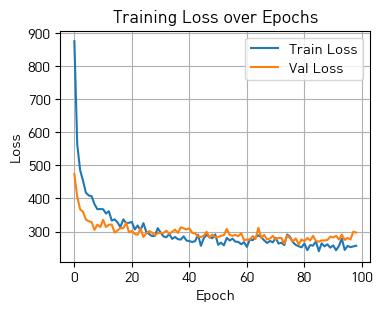

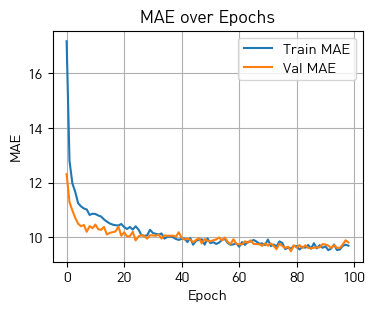

In [42]:
# 평가
loss, mae = model.evaluate(X_test, y_test)
print("Test MAE:", mae)

# 학습 히스토리 시각화
plt.figure(figsize=(4, 3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("Figures/Loss.png", bbox_inches='tight')
plt.show()

# 학습 히스토리 시각화
plt.figure(figsize=(4, 3))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("Figures/MAE.png", bbox_inches='tight')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


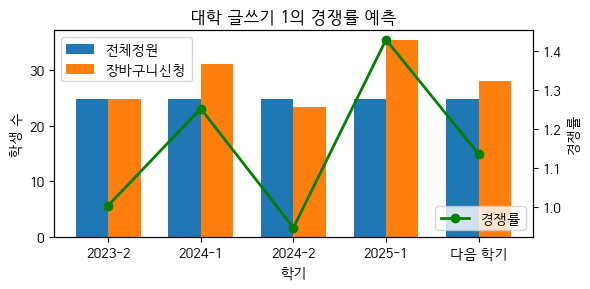

(np.float64(28.09784507751465), np.float64(1.1348521369507132))

In [8]:

model = tf.keras.models.load_model("Models/main.keras", safe_mode=False)
def get_result(custom_lecture, custom_lim=-1, graph_cnt=-1):
    if not (custom_lecture in df_sorted["교과목명"].unique()):
        raise ValueError('Cannot find lecture.')
    
    datas = df_sorted[df_sorted["교과목명"]==custom_lecture]
    semesters = datas["semester_idx"].unique()
    
    sem_data_list = []
    
    for i in range(len(semesters)):
        sem_data = datas[datas["semester_idx"]==semesters[i]]
        sem_data = X_all_sorted[sem_data.index.to_list()]
        sem_data_list.append(sem_data.mean(axis=0))
    
    sem_data_list = np.array(sem_data_list)

    if custom_lim == -1:
        custom_lim = sem_data_list[-1, -2]

    temp_lim = np.full((sem_data_list.shape[0], 1), custom_lim)
    sem_data_list = np.concatenate([sem_data_list, temp_lim], axis=1)
    
    if len(semesters) < window_size + 1:
        y_pred = np.array([[sem_data_list[-1, -2]]])
    else:
        custom_data = np.expand_dims(sem_data_list[-window_size:], axis=0)
        y_pred = model.predict(custom_data)

    semester_sum = np.vectorize(lambda x: str(x)[:-1] + "-" + str(x)[-1])(semesters)
    semester_sum = np.concatenate([semester_sum, ["다음 학기"]])
    
    x_index = range(len(semester_sum))
    bar_width = 0.35

    lim = np.concatenate([sem_data_list[:, -3], [custom_lim]])
    res = np.concatenate([sem_data_list[:, -2], y_pred[0]])
    ratio = res / lim

    if graph_cnt != -1:
        x_index = range(graph_cnt)
        semester_sum = semester_sum[-graph_cnt:]
        lim = lim[-graph_cnt:]
        res = res[-graph_cnt:]
        ratio = ratio[-graph_cnt:]

    fig, ax1 = plt.subplots(figsize=(6, 3))
    bars1 = ax1.bar(semester_sum, lim, width=bar_width, label='전체정원')
    bars2 = ax1.bar([i + bar_width for i in x_index], res, width=bar_width, label='장바구니신청')
    ax1.set_xlabel('학기')
    ax1.set_ylabel('학생 수')
    ax1.set_xticks([i + bar_width / 2 for i in x_index], semester_sum)
    # legend = ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1.0))
    

    ax2 = ax1.twinx()
    line, = ax2.plot([i + bar_width / 2 for i in x_index], ratio, label='경쟁률', color='green', marker='o', linewidth=2, zorder=1)
    ax2.set_ylabel('경쟁률')
    # ax2.legend(loc='upper left', bbox_to_anchor = (1.2, 0.75))
    legend = ax1.legend(loc='upper left')
    legend.set_zorder(100)
    legend = ax2.legend(loc = 'lower right')
    legend.set_zorder(10)

    plt.title(f'{custom_lecture}의 경쟁률 예측')
    
    plt.tight_layout()
    plt.show()
    
    return res[-1], ratio[-1]

get_result("대학 글쓰기 1", graph_cnt = 5)

In [12]:
datas

1,교과구분,개설대학,개설학과,이수과정,학년,교과목명,학점,강의,실습,수업교시,주담당교수,장바구니신청,전체정원,경쟁률,연도,학기,semester_idx,row_index
67680,전선,인문대학,아시아언어문명학부,학사,3,힌디어강독,3,3,0,16.5,이동원,1,20,0.05,2021,1,20211,4050
67681,전선,인문대학,아시아언어문명학부,학사,3,힌디어강독,3,3,0,14.0,이동원,3,20,0.15,2023,1,20231,35222
67682,전선,인문대학,아시아언어문명학부,학사,3,힌디어강독,3,3,0,11.0,스리잔 꾸마르,4,20,0.20,2025,1,20251,60723


In [13]:
datas["경쟁률"].iloc[-1]

np.float64(0.2)

In [14]:
X_seq_test = []
lecture_names = []
X_ratio_test = []

grouped = df_sorted.groupby("교과목명")

for name, group in grouped:
    idxs = group.index.to_list()
    datas = df_sorted.loc[idxs]
    semesters = df_sorted.loc[idxs]["semester_idx"].unique()
    
    if len(semesters) < window_size + 1:
        continue

    sem_data_list = []
    
    for i in range(len(semesters)):
        sem_data = datas[datas["semester_idx"]==semesters[i]]
        sem_data = X_all_sorted[sem_data.index.to_list()]
        sem_data_list.append(sem_data.mean(axis=0))

    sem_data_list = np.array(sem_data_list)
    
    seq = sem_data_list[-window_size-1:-1]
    
    temp_lim = np.full((seq.shape[0], 1), sem_data_list[-1, -2:-1])

    seq = np.concatenate([seq, temp_lim], axis=1)

    X_seq_test.append(seq)
    lecture_names.append(name)
    X_ratio_test.append(datas["경쟁률"].iloc[-1])

X_seq_test = np.array(X_seq_test)  # shape (n_samples, 5, n_features)
X_seq_test = np.nan_to_num(X_seq_test, nan=0.0)

print("X_seq shape:", X_seq_test.shape)

X_seq shape: (4325, 3, 20)


In [15]:
X_ratio_test = np.array(X_ratio_test)

In [16]:
y_pred_test = model.predict(X_seq_test)
y_pred_test = y_pred_test[:, 0]
lim_test = X_seq_test[:, -1, -1]
ratio_test = y_pred_test/lim_test

idxs = [0 for _ in range(len(lecture_names))]
grouped = df_sorted.groupby("교과목명")

for name, group in grouped:
    if name in lecture_names:
        idxs[lecture_names.index(name)] = group.index.to_list()[-1]

df_res = pd.DataFrame({"전체정원": lim_test,"예측 장바구니신청": y_pred_test, "예측 경쟁률": ratio_test, "실제 경쟁률": X_ratio_test})
temp_cols = df_sorted.loc[idxs].reset_index(drop=True).drop(columns=["전체정원"])
df_res = pd.concat([temp_cols, df_res], axis=1)
df_res.drop(columns=["학점", "강의", "실습", "수업교시", "장바구니신청", "연도", "학기", "semester_idx", "row_index", "경쟁률", "주담당교수"], inplace=True)


df_print = df_res.sort_values("예측 경쟁률", ascending=False)
df_print[df_print["이수과정"]=="학사"][:20].drop(columns=["교과구분", "개설대학", "이수과정", "학년", "전체정원", "예측 장바구니신청"])

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,개설학과,교과목명,예측 경쟁률,실제 경쟁률
972,공예과,도예의 기초,7.082970,5.583333
1458,법학과,범죄와 형벌,5.966741,4.283333
2390,체육교육과,양궁,5.065448,3.100000
2100,음악학과,"스튜디오 뮤직 메이킹 (로직, 거라지밴드) 입문",4.827441,2.800000
2101,음악학과,"스튜디오 뮤직 메이킹 (로직, 사운드 디자인) 입문",4.497430,3.666667
2024,체육교육과,수영 3(자유형),4.002312,2.450000
158,언론정보학과,게임의 이해,3.885602,2.150000
1663,체육교육과,산과 인생,3.708306,3.266667
2254,NaN,신입생세미나,3.390047,1.800000
349,체육교육과,골프초급,3.370210,2.800000


In [19]:
df_print["예측 경쟁률"] = df_print["예측 경쟁률"].apply(lambda x: 0 if x<0 else x)

In [20]:
err = df_print["예측 경쟁률"] - df_print["실제 경쟁률"]
err

3213    0.238515
2598    2.321328
3639    1.303238
972     1.499637
1513   -0.535368
          ...   
3460   -0.116667
3697   -0.250000
3211    0.000000
4293   -0.400000
2982    0.000000
Length: 4325, dtype: float64

In [21]:
err.describe()

count    4325.000000
mean        0.006060
std         0.343595
min        -2.157901
25%        -0.153213
50%         0.018497
75%         0.172875
max         5.986619
dtype: float64

Text(0.5, 0, '경쟁률 오차')

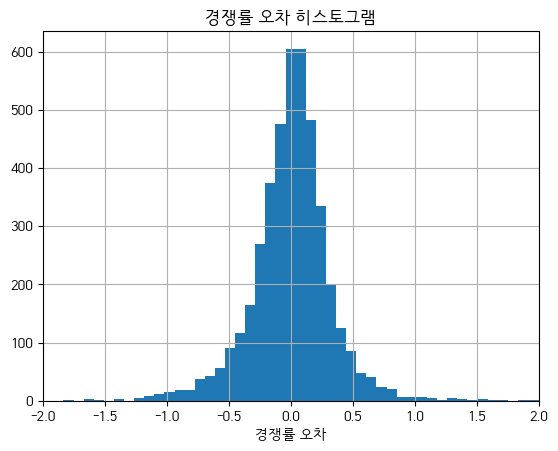

In [30]:
err.hist(bins=100)
plt.xlim(-2, 2)
plt.title("경쟁률 오차 히스토그램")
plt.xlabel("경쟁률 오차")

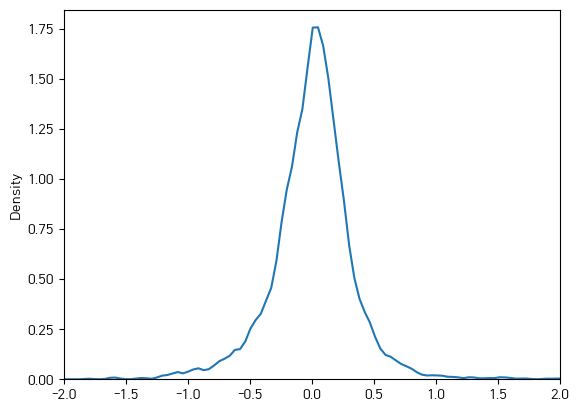

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(err, bw_adjust=0.5)  # bw_adjust로 부드러움 조절
plt.xlim(-2, 2)
plt.show()


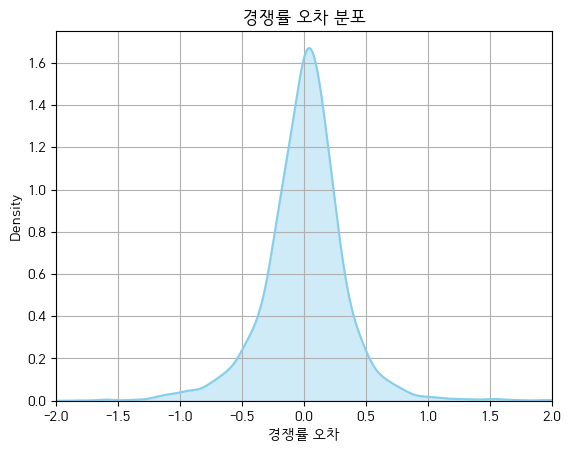

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# KDE 계산
density = gaussian_kde(err)
x = np.linspace(-2, 2, 1000)
y = density(x)

# 그래프 그리기
plt.plot(x, y, color='skyblue')            # 외곽선
plt.fill_between(x, y, color='skyblue', alpha=0.4)  # 내부 채우기

# 축 설정
plt.xlim(-2, 2)
plt.ylim(0, 1.75)
plt.xlabel("경쟁률 오차")
plt.ylabel("Density")
plt.title("경쟁률 오차 분포")
plt.grid(True)
plt.show()


In [40]:
model.save("Models/main.keras")